In [1]:
#import get to call a get request on the site
from requests import get

#get the first page of the east bay housing prices
#get rid of those lame-o's that post a housing option without a pic using their filter
response = get('https://sfbay.craigslist.org/search/scz/apa?hasPic=1&availabilityMode=0') 

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print(len(posts)) #to double check I got 120 (elements/page)

<class 'bs4.element.ResultSet'>
120


In [2]:
#grab the first post
post_one = posts[0]

In [3]:
#grab the price of the first post
post_one_price = post_one.a.text
post_one_price.strip()

'$2300'

In [4]:
#grab the time of the post in datetime format to save on cleaning efforts
post_one_time = post_one.find('time', class_= 'result-date')
post_one_datetime = post_one_time['datetime']

In [5]:
#title is a and that class, link is grabbing the href attribute of that variable
post_one_title = post_one.find('a', class_='result-title hdrlnk')
post_one_link = post_one_title['href']

#easy to grab the post title by taking the text element of the title variable
post_one_title_text = post_one_title.text

In [6]:
#grabs the whole segment of housing details. We will need missing value handling in the loop as this kind of detail is not common in posts
#the text can be split, and we can use indexing to grab the elements we want. number of bedrooms is the first element.
#sqft is the third element

post_one_num_bedrooms = post_one.find('span', class_ = 'housing').text.split()[0]

#post_one_sqft = post_one.find('span', class_ = 'housing').text.split()[2][:-3] #cleans the ft2 at the end

In [7]:
#the neighborhood is grabbed by finding the span class 'result-hood' and pulling the text element from that
post_one_hood = posts[0].find('span', class_='result-hood').text

In [8]:
#build out the loop
#Here is the main part of the code that makes this work. This section takes all of the data from the website and sorts it
#in such a way that allows us to cleanly see what we have to work with.
from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

#each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for page in pages:
    
    #get request
    response = get("https://sfbay.craigslist.org/search/scz/apt?" 
                   + "s=" #the parameter for defining the page number 
                   + str(page) #the page number in the pages array from earlier
                   + "&hasPic=1"
                   + "&availabilityMode=0")

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            post_price = int(post.a.text.strip().replace("$", "")) 
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!


Scrape complete!


In [9]:
#This creates a nice visual of exactly how many posts were recorded and some of the info that is in those posts along
#with showing the first 10 pulled which are the most recent posts. 
import pandas as pd

eb_apts = pd.DataFrame({'posted': post_timing,
                       'neighborhood': post_hoods,
                       'post title': post_title_texts,
                       'number bedrooms': bedroom_counts,
                        'sqft': sqfts,
                        'URL': post_links,
                       'price': post_prices})
print(eb_apts.info())
eb_apts.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595 entries, 0 to 594
Data columns (total 7 columns):
posted             595 non-null object
neighborhood       595 non-null object
post title         595 non-null object
number bedrooms    545 non-null object
sqft               440 non-null float64
URL                595 non-null object
price              595 non-null int64
dtypes: float64(1), int64(1), object(5)
memory usage: 32.6+ KB
None


posted                         neighborhood  \
0  2019-10-14 20:03                              (aptos)   
1  2019-10-14 19:49                           (capitola)   
2  2019-10-14 19:48                           (capitola)   
3  2019-10-14 19:05                         (santa cruz)   
4  2019-10-14 19:00                              (aptos)   
5  2019-10-14 18:45                         (santa cruz)   
6  2019-10-14 18:21                         (santa cruz)   
7  2019-10-14 17:55   (6440 Highway 9, Felton, CA 95018)   
8  2019-10-14 17:37                         (santa cruz)   
9  2019-10-14 17:29                        (watsonville)   

                                          post title number bedrooms    sqft  \
0  1 Bed, 1 Bath apt /w ocean views & large priva...               1   850.0   
1                                Rosedale Apartments               2   800.0   
2       Capitola Hill Apartments near Gayle's Bakery               1   630.0   
3  One level 2 bedroom duplex with garage n pvt y...               2  1000.0   
4  Aptos/Seascape Townhome  Spacious 2Bd/2Ba $260...               2  1475.0   
5  Jr 1br Top Floor, Corner Unit - Take Over Leas...               1   345.0   
6           Pet Friendly Walk to Beach November FREE               2   771.0   
7  On the River! - Great Studio Cottage $1300 + $...             NaN   300.0   
8                        5 bedroom home by the beach               5  2400.0   
9                                  Beatiful Townhome               2  1000.0   

                                                 URL  price  
0  https://sfbay.craigslist.org/scz/apa/d/aptos-1...   2300  
1  https://sfbay.craigslist.org/scz/apa/d/capitol...   2195  
2  https://sfbay.craigslist.org/scz/apa/d/capitol...   1875  
3  https://sfbay.craigslist.org/scz/apa/d/santa-c...   2250  
4  https://sfbay.craigslist.org/scz/apa/d/aptos-a...   2600  
5  https://sfbay.craigslist.org/scz/apa/d/jr-1br-...   1950  
6  https://sfbay.craigslist.org/scz/apa/d/santa-c...   3055  
7  https://sfbay.craigslist.org/scz/apa/d/mount-h...   1300  
8  https://sfbay.craigslist.org/scz/apa/d/santa-c...   6425  
9  https://sfbay.craigslist.org/scz/apa/d/beatifu...   3050

In [10]:
#first things first, drop duplicate URLs because people are spammy on Craigslist. 
#Let's see how many uniqe posts we really have.
eb_apts = eb_apts.drop_duplicates(subset='URL')
len(eb_apts.drop_duplicates(subset='URL'))

#make the number bedrooms to a float (since np.nan is a float too)
eb_apts['number bedrooms'] = eb_apts['number bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to be able to work with it
from datetime import datetime

eb_apts['posted'] = pd.to_datetime(eb_apts['posted'])

#Looking at what neighborhoods there are with eb_apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

#remove the parenthesis from the left and right of the neighborhoods
eb_apts['neighborhood'] = eb_apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))

#titlecase them
eb_apts['neighborhood'] = eb_apts['neighborhood'].str.title()

#just take the first name of the neighborhood list, splitting on the '/' delimiter
eb_apts['neighborhood'] = eb_apts['neighborhood'].apply(lambda x: x.split('/')[0])

#fix one-offs that
#eb_apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
#eb_apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)

#remove whitespaces
eb_apts['neighborhood'] = eb_apts['neighborhood'].apply(lambda x: x.strip())

In [11]:
#Here is our list of data after removing all of the duplicates. 
eb_apts.info()
#Here is something I added to allow us to study the data and save it for comparison
eb_apts.to_csv('dataframe.csv')
eb_apts.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 0 to 118
Data columns (total 7 columns):
posted             119 non-null datetime64[ns]
neighborhood       119 non-null object
post title         119 non-null object
number bedrooms    109 non-null float64
sqft               88 non-null float64
URL                119 non-null object
price              119 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 7.4+ KB


posted                       neighborhood  \
0 2019-10-14 20:03:00                             (Aptos   
1 2019-10-14 19:49:00                          (Capitola   
2 2019-10-14 19:48:00                          (Capitola   
3 2019-10-14 19:05:00                        (Santa Cruz   
4 2019-10-14 19:00:00                             (Aptos   
5 2019-10-14 18:45:00                        (Santa Cruz   
6 2019-10-14 18:21:00                        (Santa Cruz   
7 2019-10-14 17:55:00  (6440 Highway 9, Felton, Ca 95018   
8 2019-10-14 17:37:00                        (Santa Cruz   
9 2019-10-14 17:29:00                       (Watsonville   

                                          post title  number bedrooms    sqft  \
0  1 Bed, 1 Bath apt /w ocean views & large priva...              1.0   850.0   
1                                Rosedale Apartments              2.0   800.0   
2       Capitola Hill Apartments near Gayle's Bakery              1.0   630.0   
3  One level 2 bedroom duplex with garage n pvt y...              2.0  1000.0   
4  Aptos/Seascape Townhome  Spacious 2Bd/2Ba $260...              2.0  1475.0   
5  Jr 1br Top Floor, Corner Unit - Take Over Leas...              1.0   345.0   
6           Pet Friendly Walk to Beach November FREE              2.0   771.0   
7  On the River! - Great Studio Cottage $1300 + $...              NaN   300.0   
8                        5 bedroom home by the beach              5.0  2400.0   
9                                  Beatiful Townhome              2.0  1000.0   

                                                 URL  price  
0  https://sfbay.craigslist.org/scz/apa/d/aptos-1...   2300  
1  https://sfbay.craigslist.org/scz/apa/d/capitol...   2195  
2  https://sfbay.craigslist.org/scz/apa/d/capitol...   1875  
3  https://sfbay.craigslist.org/scz/apa/d/santa-c...   2250  
4  https://sfbay.craigslist.org/scz/apa/d/aptos-a...   2600  
5  https://sfbay.craigslist.org/scz/apa/d/jr-1br-...   1950  
6  https://sfbay.craigslist.org/scz/apa/d/santa-c...   3055  
7  https://sfbay.craigslist.org/scz/apa/d/mount-h...   1300  
8  https://sfbay.craigslist.org/scz/apa/d/santa-c...   6425  
9  https://sfbay.craigslist.org/scz/apa/d/beatifu...   3050

In [12]:
import pandas as pd, numpy as np
#I think Craigslist blocked me. Reload dataframe via file for now
#eb_apts = pd.read_csv("eb_apts_1642_Jan_2_19_clean.csv")

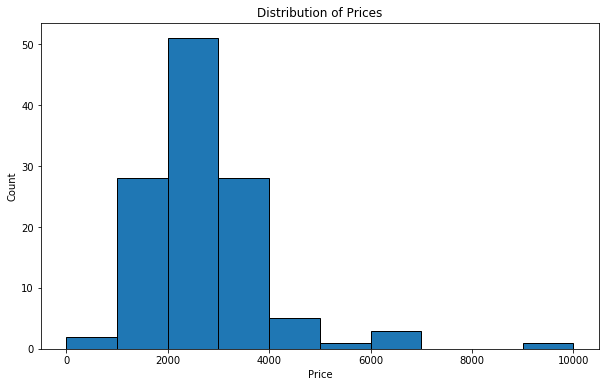

In [13]:
#start to look at the distributions
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.hist(eb_apts['price'], edgecolor='black');
plt.xlabel("Price")
plt.ylabel('Count')
plt.title("Distribution of Prices");

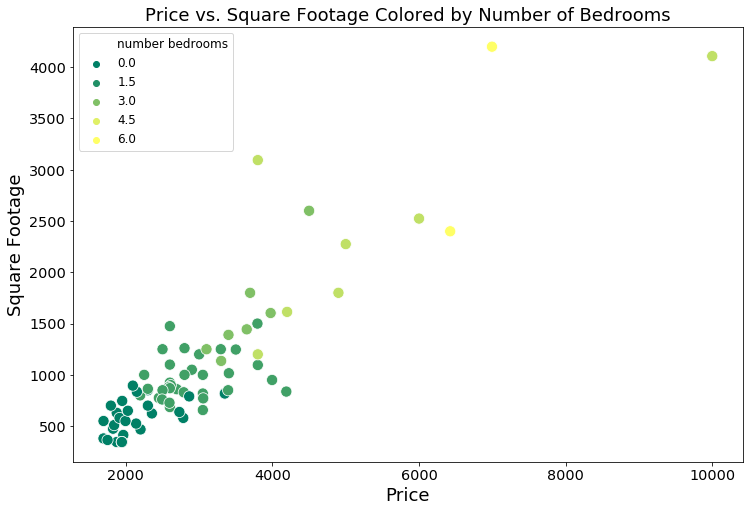

In [14]:
#Here we are creating a scatter plot. This gives us a pretty clear indication of the price to room ratio.
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='price', y='sqft', hue='number bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=eb_apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);

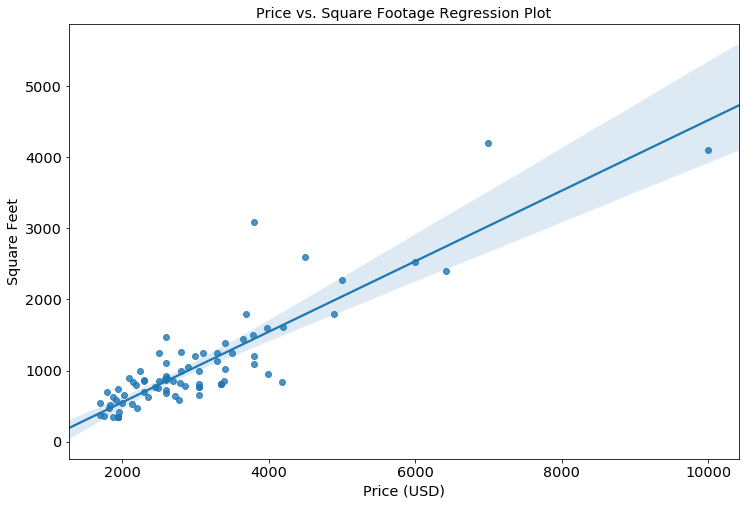

In [15]:
#Here we can see a linear regression plot that shows us the relation between the size of the places for rent
#and their cost. 
plt.figure(figsize=(12, 8))
sns.regplot(x='price', y='sqft', data=eb_apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price (USD)");
plt.ylabel("Square Feet");

In [16]:
#This is a simple method that shows the relation between the number of bedrooms, the sqft and the price.
eb_apts.corr()

number bedrooms      sqft     price
number bedrooms         1.000000  0.842093  0.792308
sqft                    0.842093  1.000000  0.886681
price                   0.792308  0.886681  1.000000

In [17]:
#group by neighborhood
eb_apts.groupby('neighborhood').mean()

number bedrooms         sqft        price
neighborhood                                                                
(6440 Highway 9, Felton, Ca 95018              NaN   300.000000  1300.000000
(Aptos                                    2.529412  1444.333333  3230.000000
(Boulder Creek                            1.000000   746.000000  1950.000000
(Capitola                                 2.166667  1157.142857  3141.428571
(Felton                                        NaN          NaN  1800.000000
(Prunedale                                1.000000          NaN  1000.000000
(Santa Cruz                               1.868421   859.859649  2677.609756
(Scotts Valley                            1.333333   658.333333  1420.000000
(Soquel                                   2.333333  2516.000000  4200.333333
(Watsonville                              1.500000   682.500000  2400.000000

In [18]:
#sort price to find cheapest
eb_apts.groupby('neighborhood').mean()['price'].sort_values()

neighborhood
(Prunedale                           1000.000000
(6440 Highway 9, Felton, Ca 95018    1300.000000
(Scotts Valley                       1420.000000
(Felton                              1800.000000
(Boulder Creek                       1950.000000
(Watsonville                         2400.000000
(Santa Cruz                          2677.609756
(Capitola                            3141.428571
(Aptos                               3230.000000
(Soquel                              4200.333333
Name: price, dtype: float64

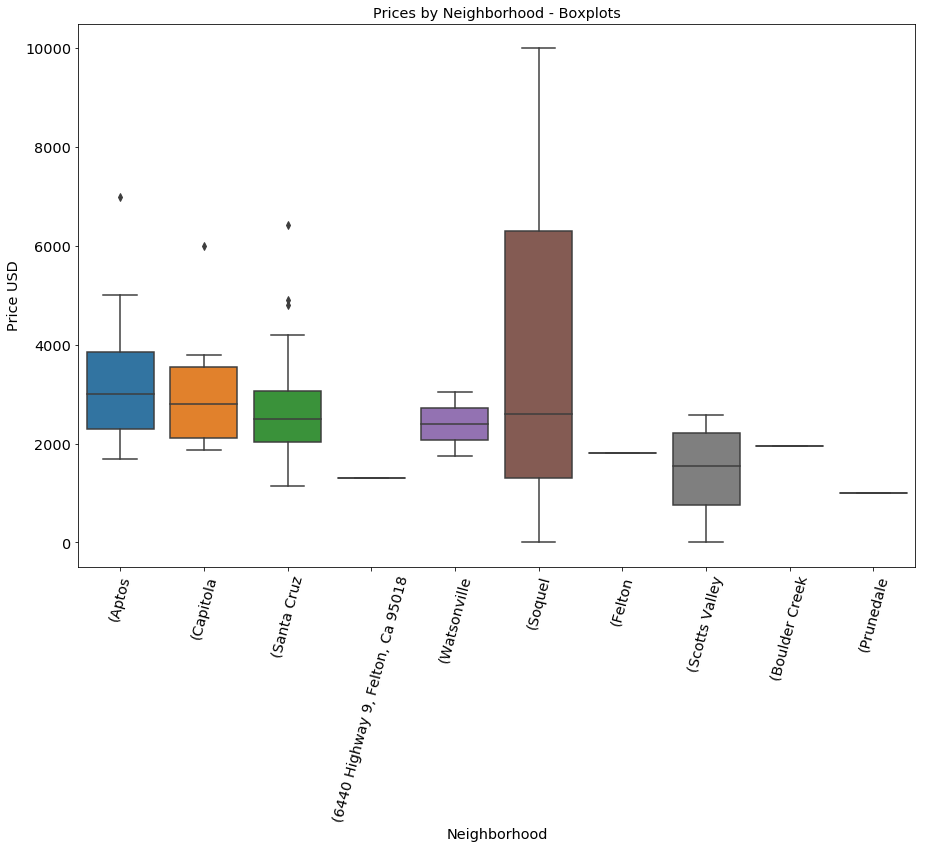

In [19]:
#Here we can see the varying prices of homes in each neighborhood using a boxplot. 
plt.figure(figsize=(15,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.boxplot(x='neighborhood', y='price', data=eb_apts)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots");